In [14]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
import csv

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Загружаю датасет отзывов об aple (взят с Kaggle , скрин kaggle_set.png)
reviews = pd.read_csv('data_aple',engine='python',encoding='utf-8', on_bad_lines='skip')

In [16]:
#Смотрю состав датасета
reviews.head()

,Unnamed: 0.1,Unnamed: 0,Review,Rating,label
0,0,0,3D Touch просто восхитительная вещь! Заряд дер...,5.0,1
1,1,1,"Отключается при температуре близкой к нулю, не...",4.0,1
2,2,2,"В Apple окончательно решили не заморачиваться,...",3.0,0
3,3,3,Постарался наиболее ёмко и коротко описать все...,4.0,1
4,4,4,Достойный телефон. Пользоваться одно удовольст...,5.0,1


In [17]:
#Проверяю типы данных
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90097 entries, 0 to 90096
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  90097 non-null  int64  
 1   Unnamed: 0    90097 non-null  object 
 2   Review        89177 non-null  object 
 3   Rating        87899 non-null  float64
 4   label         90097 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 3.4+ MB


In [18]:
# Создаю функцию для присвоения метки по правилу : Rating = 5,4 - 1(положит); Rating 3,2,1 - 0(отрицат)
def assigning_label(score):
    if score >= 4:
        return int(1)
    else:
        return int(0)

In [19]:
# Присваиваю метки согласно столбца Rating
reviews['label'] = reviews['Rating'].apply(assigning_label)

In [20]:
#Проверяю измененный датасет
reviews.head()

,Unnamed: 0.1,Unnamed: 0,Review,Rating,label
0,0,0,3D Touch просто восхитительная вещь! Заряд дер...,5.0,1
1,1,1,"Отключается при температуре близкой к нулю, не...",4.0,1
2,2,2,"В Apple окончательно решили не заморачиваться,...",3.0,0
3,3,3,Постарался наиболее ёмко и коротко описать все...,4.0,1
4,4,4,Достойный телефон. Пользоваться одно удовольст...,5.0,1


In [21]:
import matplotlib.pyplot as plt

<Axes: >

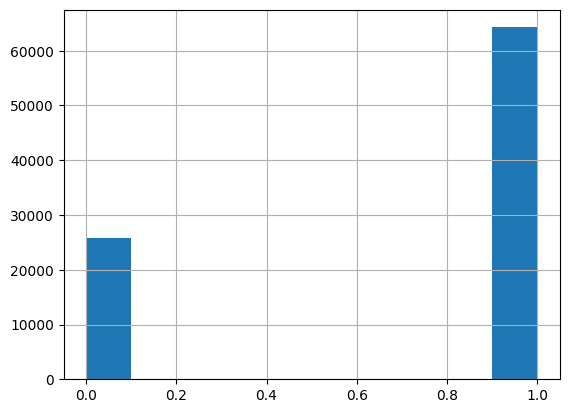

In [22]:
# Смотрю графически рапределение положительных и отрицательных отзывов
reviews['label'].hist()

In [23]:
# Произведу разметку датасета с активным обучением
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

In [27]:
# Перемешиваю данные
reviews = shuffle(reviews)

In [28]:
# Разделяю датасет на размеченную и неразмеченную части
labeled_reviews, unlabeled_reviews = train_test_split(reviews, train_size=0.2, random_state=52)

In [29]:
labeled_reviews.head()

,Unnamed: 0.1,Unnamed: 0,Review,Rating,label
22014,22014,21646,Считаю телефон соответствует соотношению цена-...,4.0,1
59156,59156,58133,"лопнул тачскин,вечером поставил на зарядку-утр...",1.0,0
76116,76116,74890,"Перешел с samsung S8, пока всем доволен. Сразу...",5.0,1
26797,26797,26310,"Долго выбирал себе новую трубку, вместо Меизу ...",4.0,1
20466,20466,20118,"Довольна покупкой, думаю что купила бы снова",4.0,1


In [30]:
unlabeled_reviews.head()

,Unnamed: 0.1,Unnamed: 0,Review,Rating,label
17566,17566,17282,ну в целом модель хорошая. цена соответствует ...,4.0,1
28777,28777,28255,"Самый главный недостаток заключается в том, чт...",1.0,0
33281,33281,32699,Очень долго выбирал из разных производителей в...,5.0,1
14884,14884,14665,"после покупки страшно тупил, через день перест...",1.0,0
76296,76296,75067,"Купили s6 и а5 2016г,до него был LG g4 и htc m...",5.0,1


In [31]:
# Создаю функцию для обучения модели логистической регрессии на размеченных данных
def train_model(labeled_reviews):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(labeled_reviews['Review'].values.astype('U')) # .values.astype('U') - преобразуем объект в текст
    y = labeled_reviews['label']

    # Обучение модели логистической регрессии на размеченных данных
    model = LogisticRegression()
    model.fit(X, y)

    return model, vectorizer

In [32]:
# Обучаю начальную модель на малой части
model, vectorizer = train_model(labeled_reviews)

In [33]:
# Исходная модель для прогнозирования неразмеченных данных
X_unlabeled = vectorizer.transform(unlabeled_reviews['Review'].values.astype('U'))
y_unlabeled_predicted = model.predict(X_unlabeled)

In [34]:
# Вычисляю неопределенности или энтропии предсказаний
y_unlabeled_proba = model.predict_proba(X_unlabeled)
uncertainty = -(y_unlabeled_proba * np.log2(y_unlabeled_proba)).sum(axis=1)

In [35]:
# Выбор 100 наиболее неопределенных точек данных для маркировки человеком
labeled_reviews_new = unlabeled_reviews.iloc[uncertainty.argsort()[:100]]
unlabeled_reviews_new = unlabeled_reviews.iloc[uncertainty.argsort()[100:]]

In [36]:
# Разметка новых точек данных и добавление их к размеченному множеству
labeled_reviews = pd.concat([labeled_reviews, labeled_reviews_new])

In [37]:
# Переобучение модели на расширенном маркированном множестве
model, vectorizer = train_model(labeled_reviews)

In [38]:
reviews_test = pd.read_csv('aple_test', engine='python',encoding='utf-8', on_bad_lines='skip')

In [39]:
# Оценка модели на тестовом датасете
X_test = vectorizer.transform(reviews_test['Review'].values.astype('U'))
y_test_predicted = model.predict(X_test)
f1 = f1_score(reviews_test['label'], y_test_predicted)

print(f1)

0.8885958747799375
